# Hands-on Example: Build an Assimilation System with PDAF

In this practical, we will build a data assimilation system using pyPDAF. pyPDAF is a Python interface to PDAF (Parallel Data Assimilation Framework). The framework is mainly designed for ensemble data assimilation systems with high-dimensional complex weather and climae models. It was used for both research and operational purposes. The Python interface allows for the use of PDAF with Python models.

As per its name, the framework is designed with the aim to implement efficient parallelised data assimilation system. In this practical, to illustrate the workflow of PDAF, we do not provide parallelisation module. A parallelised example will be given separately.

## Install conda (a Python package manager) and pyPDAF

Before we get into the implementation, we need to install pyPDAF. We need to first install conda. It will restart the kernel of the notebook.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

RuntimeError: This module must ONLY run as part of a Colab notebook!

Now, we can install pyPDAF using conda

In [1]:
%%capture
# installation of pyPDAF
!conda install -c yumengch -c conda-forge pypdaf

To provide a better view of PDAF output, we use wurlitzer

In [2]:
%%capture
# wurlitzer is a package that allows us to see PDAF output
!pip install wurlitzer

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

## A short introduction to the example 2D model

- Spatial Domain: Two dimensional domain grid domain with 36 × 18 grid points
- Total steps: we will run this model by 18 time steps

With this information, we can define the model variable,

In [4]:
# define the array for model field
nsteps = 18 # total time steps
nx = 36 # 36 columns
ny = 18 # 18 rows
# initial condition + 18 time steps, 18 rows and 36 columns
field = np.zeros((nsteps + 1, ny, nx))

The initial condition of the model is a sine wave in the diagonal direction:

In [5]:
"""read the initial condition of the model field"""
field[0] = np.loadtxt('inputs_online/true_initial.txt')

The model shifts the sine wave along the y-axis by one grid point per time step

In [6]:
def step(field):
    """Roll array elements of i-th time step along a the first axis."""
    return np.roll(field, shift=1, axis=-2)

### How does the model look like?

We can visualise the model propagation:

In [7]:
fig = plt.figure('animation')
def draw_model(i):
  """Draw each model step
  """
  fig.clf()
  ax = fig.add_subplot(111)
  # run the model
  field[i+1] = step(field[i])
  pc = ax.pcolormesh(field[i+1], cmap='coolwarm', vmin=-1, vmax=1)
  ax.set_title(f'Model step {i+1}')
  fig.colorbar(pc, ax=ax)

# make an animation
anim = animation.FuncAnimation(fig, draw_model, frames=nsteps, interval=300, blit=False)
plt.close(fig)
HTML(anim.to_html5_video())

## Observations

- Select a set of observations at 28 grid points
- Observations are sampled from a Gaussian distribution with a standard deviation of 0.5
- full 2D field, -999 marks ‘no data’
- One observation file at each time step
- They're stored in 'obs_step*.txt'

In [8]:
# define observation array
obs = np.ma.zeros((nsteps, ny, nx))
fig = plt.figure('animationObs')
def draw_model(i):
  """Draw obs. at each model step
  """
  fig.clf()
  ax = fig.add_subplot(111)
  obs[i] = np.loadtxt(f'inputs_online/obs_step{i+1}.txt')
  obs[i] = np.ma.masked_where(np.isclose(obs[i], -999.), obs[i])
  cont = ax.pcolormesh(obs[i], cmap='coolwarm', vmin=-1, vmax=1)
  ax.set_title(f'Observation at step {i+1}')
  fig.colorbar(cont, ax=ax)

# make an animation
anim = animation.FuncAnimation(fig, draw_model, frames=18, interval=300, blit=False)
plt.close(fig)
HTML(anim.to_html5_video())

### Let's check the observation error

Is it close to the standard deviation of 0.5?

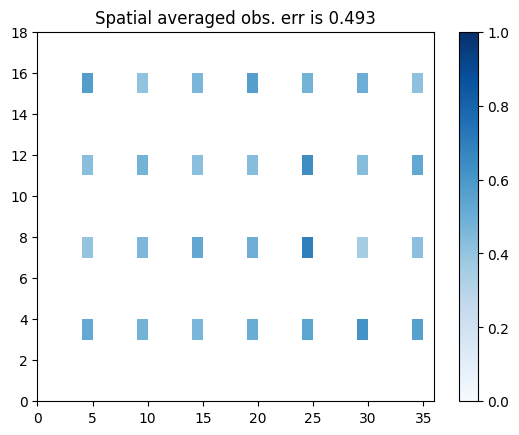

In [9]:
# calculate the root mean squared obs. err in time
err = np.sqrt(np.sum((field[1:] - obs)**2, axis=0)/nsteps)
# plot the observation error
fig = plt.figure('R')
ax = fig.add_subplot(111)
pc = ax.pcolormesh(err, cmap='Blues', vmin=0., vmax=1.)
ax.set_title(f'Spatial averaged obs. err is {np.round(np.mean(err), 3)}')
fig.colorbar(pc, ax=ax)

## Set up a data assimilation system using pyPDAF

We first import necessary packages. In this simple example, we only need pyPDAF, numpy and mpi4py. We will not use parallisation in this example, but we still need mpi4py for running PDAF.

In [7]:
import pyPDAF.PDAF as PDAF
import mpi4py.MPI as MPI
import numpy as np
from wurlitzer import pipes

### Initialise PDAF

The initialisation of PDAF tells PDAF the our choice of data assimilation algorithms, ensemble size, inflation factor, and the dimension of the state vector. In this example, for the sake of simplicity, we do not use any localisation and no inflation is applied.

The **standard error space transform Kalman filter (ESTKF)** is used with **9** ensemble members. We will estimate the state of every model grid point, which gives us a state vector with the size of nx × ny = 36 × 18 = 648

In [8]:
# using error space transform Kalman filter (ESTKF)
filtertype = 6
# standard form
subtype = 0
# dimension of the state vector
# if model is parallelised, this is the dimension of state vector on each process
dim_state_p = nx*ny
# number of ensemble members
dim_ens = 9
# forget factor
forget_factor = 1.0

In addition to the basic information, PDAF also asks for an **initial ensemble**. This information is given by the user-supplied function. These functions have fixed interface. Therefore
- the input arguments and return variables should not be changed.

The initial ensemble is read from given text files here. In real applications, we may need to use algorithms to generate perturbations to create an initial ensemble. For the sake of conciseness, documentation of the input arguments and return variable of this function can be found in [pyPDAF documentation](https://yumengch.github.io/pyPDAF/UserFunc.html#pyPDAF.UserFunc.py__init_ens_pdaf) and [PDAF documentation](https://pdaf.awi.de/trac/wiki/U_init_ens)

In [9]:
def init_ens_pdaf(filtertype, dim_p, dim_ens, state_p, uinv, ens_p, status_pdaf):
    """Here, only ens_p variable matters while dim_p and dim_ens defines the
    size of the variables. uinv, state_p are not used in this example.

    status_pdaf is used to handle errors which we will not do it in this example.
    """
    for i in range(dim_ens):
        ens_p[:, i] = np.loadtxt(f'inputs_online/ens_{i+1}.txt').ravel()
    return state_p, uinv, ens_p, status_pdaf

With these information, we can call PDAF function [`PDAF.init`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.init) to initialise the DA system

In [10]:
# this gives the verbose level of the PDAF, here we use 3 which is very verbose
screen = 3
# current step of the model which is 0
current_step = 0
with pipes() as (out, err):
    _, _, status = PDAF.init(filtertype, subtype, current_step,
                            np.array([dim_state_p, dim_ens]),
                            np.array([forget_factor, ]),
                            MPI.COMM_WORLD.py2f(), MPI.COMM_WORLD.py2f(),
                            MPI.COMM_WORLD.py2f(),
                            task_id=1, n_modeltasks=1, in_filterpe=True,
                            py__init_ens_pdaf=init_ens_pdaf,
                            in_screen=screen)
# print PDAF screen output
print (out.read())


PDAF    ++++++++++++++++++++++++++++++++++++++++++++++++++++++
PDAF    +++                      PDAF                      +++
PDAF    +++      Parallel Data Assimilation Framework      +++
PDAF    +++                                                +++
PDAF    +++                 Version 2.1                    +++
PDAF    +++                                                +++
PDAF    +++                 Please cite                    +++
PDAF    +++     L. Nerger and W. Hiller, Computers and     +++
PDAF    +++         Geosciences, 2013, 55, 110-118,        +++
PDAF    +++         doi:10.1016/j.cageo.2012.03.026        +++
PDAF    +++ when publishing work resulting from using PDAF +++
PDAF    ++++++++++++++++++++++++++++++++++++++++++++++++++++++


PDAF: Initialize filter

PDAF    ++++++++++++++++++++++++++++++++++++++++++++++++++++++
PDAF    +++ Error Subspace Transform Kalman Filter (ESTKF) +++
PDAF    +++                                                +++
PDAF    +++  Nerger et al.,

### Distribution of the ensemble from PDAF
After PDAF initialisation, PDAF should distribute the ensemble back to the model for the following forecast. Three user-supplied functions are needed:
1. PDAF should distribute the initial ensemble to the model for following model forecasts [(`distribute_state`)](https://yumengch.github.io/pyPDAF/UserFunc.html#pyPDAF.UserFunc.py__distribute_state_pdaf)
2. The ensemble might need some processing before being distributed to the model [(`initial_process`)](https://yumengch.github.io/pyPDAF/UserFunc.html#pyPDAF.UserFunc.py__prepoststep_pdaf)
3. PDAF will need to know how many steps the forecast will take. In other words, when do we do the next data assimilation analysis. That is, when will the next observation arrive? [(`next_observation`)](https://yumengch.github.io/pyPDAF/UserFunc.html#pyPDAF.UserFunc.py__next_observation_pdaf)

In this example, we define a class of `PDAF_distributor` for these user-supplied functions.

In [11]:
class PDAF_distributor:
    def __init__(self, nx, ny, dim_ens):
        # counter for the i-th ensemble member when distribute
        self.i_ens_pdaf = 0
        # define the model field based on the ensemble
        self.nx, self.ny = nx, ny
        self.field = np.zeros((dim_ens, ny, nx))


In this non-parallel code, PDAF will distribute ensemble members one by one with `distribute_state` method. It is useful to keep a counter for the index of currently distributed ensemble member.

In [12]:
class PDAF_distributor(PDAF_distributor):
    def distribute_state(self, dim_p, state_p):
        """PDAF will distribute state vector (state_p) to model field
        """
        self.field[self.i_ens_pdaf] = state_p[:].reshape((self.ny, self.nx))
        self.i_ens_pdaf += 1
        return state_p

    def reset_ens_index(self):
        """reset ensemble index to 0
        """
        self.i_ens_pdaf = 0

In the initial-processing, we only show screen output of root mean squared error based on sampled variance.

In [13]:
class PDAF_distributor(PDAF_distributor):
    def initial_process(self, step, dim_p, dim_ens, dim_ens_p, dim_obs_p, state_p, uinv, ens_p, flag):
        """initial processing of the ensemble before it is distributed to model fields
        """
        print (f'RMS error according to sampled variance: {np.sqrt(np.mean(np.var(ens_p, axis=1)))}')
        return state_p, uinv, ens_p

When obtaining the initial ensemble, users also need to provide information about when do we do the next analysis based on the arrival of the new observations. In our case, we have observations for each time step.

In [14]:
class PDAF_distributor(PDAF_distributor):
    def next_observation(self, stepnow, nsteps, doexit, time):
        # next observation will arrive at `nsteps' steps
        nsteps = 1
        # doexit = 0 means that PDAF will continue to distribute state
        # to model for further integrations
        doexit = 0
        # model time is not used here as we only use steps to define the time
        return nsteps, doexit, time

Here, we call pyPDAF's `get_state` function where it will also execute our user-supplied functions.

In [15]:
status = 0
distributor = PDAF_distributor(nx, ny, dim_ens)
distributor.reset_ens_index()
# loop over all dimensions
for i in range(dim_ens):
    with pipes() as (out, err):
        steps, time, doexit, status = PDAF.get_state(0, 0,
                                          distributor.next_observation,
                                          distributor.distribute_state,
                                          distributor.initial_process,
                                          status)
    print (out.read())
# put model variable in distributor back to model
field = distributor.field

RMS error according to sampled variance: 0.5434035532444028


PDAF ----------------------------------------------------------------
PDAF                    +++++ ASSIMILATION +++++
PDAF ----------------------------------------------------------------
PDAF     Call pre-post routine at initial time
PDAF     --- duration of prestep:     0.004 s
PDAF Forecast -------------------------------------------------------
PDAF     Evolve state ensemble











### Forward data assimilation system

Data assimilation combines the model forecast and the observations. Hence, the data assimilation system does two things
 - model forecast
  - in this example, the `step` function is used as we defined [previously](#scrollTo=9cGn7y1usALz&line=2&uniqifier=1)
 - data assimilation, where PDAF carries out the following operations based on user-supplied functions
  - collecting state vector from model variables
  - collecting observations
  - distributing analysis back to model variables

At each analysis step, PDAF must collect the new forecast from the model and handle observations. To ensure the flexibility of the framework, these information depends on the user-supplied functions. As observations and models are always case-specific.

Here, we define two classes, `PDAF_collector` and `Obs`. The `PDAF_collector` obtains the model forecast and the `Obs` will use the `Observation Module Infrastructure` in PDAF, a scheme to ease the difficulty in handling observations.

In [16]:
class PDAF_collector:
    def __init__(self, nx, ny, field):
        # counter for the i-th ensemble member when distribute
        self.i_ens_pdaf = 0
        self.nx = nx
        self.ny = ny
        # define the model field based on the ensemble
        self.field = field

class Obs:
    def __init__(self, i_obs):
        # i_obs-th observations in the system starting from 1
        self.i_obs = i_obs

#### Collecting forecast
Before going into the details of observation handling, we first get functions that collects the model forecast [(`collect_state_pdaf`)](https://yumengch.github.io/pyPDAF/UserFunc.html#pyPDAF.UserFunc.py__collect_state) and preprocess the ensemble before the data assimilation. In the pre-processing step, we only calculate the forecast error and save the forecast ensemble. After the completion of analysis, the analysis will be postprocessed before being distributed to the model. For example, this could be dealing with bounded variables, or some transformation of the state vector. The pre- and post- processing are handled in [(`preprocess`)](https://yumengch.github.io/pyPDAF/UserFunc.html#pyPDAF.UserFunc.py__prepoststep_pdaf), where argument `step` determines whether it is pre-processing or post-processing. `step` < 0 represents pre-processing while `step` > 0 represents post-processing.

In [17]:
class PDAF_collector(PDAF_collector):
    def collect_state(self, dim_p, state_p):
        """PDAF will collect state vector (state_p) from model field
        """
        state_p[:] = self.field[self.i_ens_pdaf].ravel()
        self.i_ens_pdaf += 1
        return state_p

    def reset_ens_index(self):
        """reset ensemble index to 0
        """
        self.i_ens_pdaf = 0

    def preprocess(self, step, dim_ens, ens_p):
        """preprocessing of the ensemble before it is used by DA algorithms
        """
        print (f'Forecast RMS error according to sampled variance: {np.sqrt(np.mean(np.var(ens_p, axis=1)))}')
        for i in range(dim_ens):
            np.savetxt(f'ens_{i+1}_step{-step}_for.txt' , ens_p[:, i].reshape((self.ny, self.nx)) )

    def postprocess(self, step, dim_ens, ens_p):
        """initial processing of the ensemble before it is distributed to model fields
        """
        print (f'Analysis RMS error according to sampled variance: {np.sqrt(np.mean(np.var(ens_p, axis=1)))}')
        for i in range(dim_ens):
            np.savetxt(f'ens_{i+1}_step{step}_ana.txt' , ens_p[:, i].reshape((self.ny, self.nx)) )

    def prepostprocess(self, step, dim_p, dim_ens, dim_ens_p, dim_obs_p, state_p, uinv, ens_p, flag):
        if step < 0:
          self.preprocess(step, dim_ens, ens_p)
        else:
          self.postprocess(step, dim_ens, ens_p)
        return state_p, uinv, ens_p


#### Handling observations
Another essential ingredient of data assimilation is observation. Here, user-supplied functions give all information about the observations to PDAF. We use the OMI scheme in PDAF to handle observations. Without any localisations, only two user-supplied functions are required with the OMI scheme.

Before we use the OMI scheme, we need to provide the number of observation types by [`PDAF.omi_init`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.omi_init). Here, we use only one type of observations.

In [18]:
PDAF.omi_init(1)

In this very simple example, it may look a bit verbose, but it can be useful for more complex systems.

The OMI has four mandatory properties:
- [`doassim`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.omi_set_doassim): whether this observation is assimilated. If `doassim = 1`, this observation will be assimilated. If `doassim = 0`, it will not be assimilated.
- [`disttype`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.omi_set_disttype): In localisation, how do we calculate the distance between grid points? e.g., Cartesian, geographic, or great circle distance on a sphere. We do not use localisation in this example, but we still have to provide this option.
- [`ncoord`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.omi_set_ncoord): Number of coordinates used for computation in localisation. In our example, as we have a 2D domain, the number should be 2.
- [`id_obs_p`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.omi_set_id_obs_p): Indices of observed field in state vector. This is a 2D array that should have the same length as the observector vector for each dimension. If the observations do not need interpolation (e.g., observations are co-located with model grid points), the first dimension is 1. In this case, if the i-th observation is at the j-th element of the state vector, the i-th element of `id_obs_p` is `j`. If interpolation is needed, each dimension is the adjacent model grid points.

In the PDAF, these properties can be given to derived type `obs_f`. In the pyPDAF, setter functions are provided. PDAFomi collects the observation vector,  error variance, and the spatial coordinate of the observations in the [`PDAF.omi_gather_obs`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.omi_gather_obs) function. This function returns the dimension of the full observation vector if observation reading are performed in parallel. Therefore, we put this function call in the user-supplied function, [`init_dim_obs`](https://yumengch.github.io/pyPDAF/UserFunc.html#pyPDAF.UserFunc.py__init_dim_obs_pdaf).

In [19]:
class Obs(Obs):
    def init_dim(self, step, dim_obs):
        # We always assimilate the observation
        PDAF.omi_set_doassim(self.i_obs, 1)
        # Type of distance computation to use for localization
        # It is mandatory for OMI even if we don't use localisation
        PDAF.omi_set_disttype(self.i_obs, 0)
        # Number of coordinates use for distance computation
        PDAF.omi_set_ncoord(self.i_obs, 2)

        # read observations
        obs = np.loadtxt(f'inputs_online/obs_step{step}.txt')
        # get the dimension of the model grid
        ny, nx = obs.shape
        # flatten the observations
        obs = obs.ravel()
        # a mask for observed gridpoints
        condition = np.logical_not(np.isclose(obs, -999))

        # observation vector
        y = obs[condition]

        # The relationship between observation and state vector
        # we only have 28 osbervations and each observation corresponds to
        # the grid point of one element in the state vector
        # id_obs_p gives the indices of observed field in state vector
        # the id starts from 1
        id_obs_p = np.zeros((1, len(y)))
        id_obs_p[0] = np.arange(1, len(obs) + 1, dtype=int)[condition]
        PDAF.omi_set_id_obs_p(self.i_obs, id_obs_p)

        # inverse of observation variance
        ivar_obs_p = 1./0.5/0.5*np.ones_like(y)

        # coordinate of each observations
        ocoord_p = np.zeros((2, len(y)))
        ocoord_p[0] = np.tile(np.arange(nx), ny)[condition]
        ocoord_p[1] = np.repeat(np.arange(ny), nx)[condition]

        # not being used here, only used for localisation
        local_range = 0.
        dim_obs = PDAF.omi_gather_obs(self.i_obs, y,
                                     ivar_obs_p, ocoord_p, local_range)
        return dim_obs

The other user-supplied function in this example will be the observation operator [(`obs_op`)](https://yumengch.github.io/pyPDAF/UserFunc.html#pyPDAF.UserFunc.py__obs_op_pdaf). In this simple example, the state vector in the observation space can be conviently obtained by the OMI scheme using the information provided in the `init_dim_obs` function.

In [20]:
class Obs(Obs):
    def op(self, step, dim_p, dim_obs_p, state_p, ostate):
        """observation operator
        """
        return PDAF.omi_obs_op_gridpoint(self.i_obs, state_p, ostate)

#### Forward loop

Now, we can write code for the forward DA system:

In [21]:
steps = 0
for istep in range(nsteps):
    # model integration
    field = step(field)

    # PDAF do assimilation
    collector = PDAF_collector(nx, ny, field)
    obs = Obs(1)
    collector.reset_ens_index()
    for i in range(dim_ens):
        with pipes() as (out, err):
            status = PDAF.omi_put_state_global(collector.collect_state,
                                      obs.init_dim, obs.op,
                                      collector.prepostprocess)
        print (out.read())

    # PDAF distribute analysis back to model
    distributor = PDAF_distributor(nx, ny, dim_ens)
    distributor.reset_ens_index()
    for i in range(dim_ens):
        with pipes() as (out, err):
            # here, the distributor does not call init_process function at all
            steps, time, doexit, status = PDAF.get_state(steps, 0,
                                              distributor.next_observation,
                                              distributor.distribute_state,
                                              distributor.initial_process,
                                              status)
        print (out.read())

    field = distributor.field









Forecast RMS error according to sampled variance: 0.5434035532444028
Analysis RMS error according to sampled variance: 0.12018370986741532
PDAF     --- duration of forecast phase:     0.216 s
PDAF     Call pre-post routine after forecast; step       1
PDAF     --- duration of prestep:     0.019 s
PDAF Analysis -------------------------------------------------------
PDAF       1   Assimilating observations - ESTKF
PDAFomi     --- Use process-local observations for global filters
PDAFomi        --- Number of full observations      28
PDAF     --- PE-domain      0 dimension of observation vector        28
PDAF     Perform ensemble transformation
PDAF     --- use symmetric square-root of A
PDAF     --- Compute deterministic Omega
PDAF     --- Ensemble update: use blocking with size   200
PDAF     --- update duration:     0.005 s
PDAF     Call pre-post routine after analysis step
PDAF     --- duration of poststep:     0.018 s
PDAF Forecast -------------------------------------------